In [222]:
import pandas as pd
import numpy as np
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt


recipes = pd.read_csv(r"dishes.csv")
recipes.head()

,index,id_,name,slug,video_url,thumbnail_url,tags,cook_time,prep_time,total_time,ratings_negative,ratings_positive,score,protein,fat,calories,sugar,carbohydrates,fiber
0,0,868,Homemade Cinnamon Rolls,homemade-cinnamon-rolls,https://vid.tasty.co/output/25812/mp4_640x640/...,https://img.buzzfeed.com/video-api-prod/assets...,"7336057,6854262,5993378,5831534,1280501,124779...",30,30,151,475,17340,98.0,7.0,21.0,479.0,24.0,63.0,1.0
1,1,6124,Whipped Coffee,whipped-coffee,https://vid.tasty.co/output/163616/landscape_4...,https://img.buzzfeed.com/video-api-prod/assets...,"64487,64470,8091916,6718867,64483,64471,64465,...",0,15,15,777,8483,92.0,0.0,0.0,69.0,18.0,18.0,0.0
2,2,3094,Fluffy Pancakes,fluffy-perfect-pancakes,https://vid.tasty.co/output/65088/landscape_48...,https://img.buzzfeed.com/thumbnailer-prod-us-e...,"64469,8091748,8091747,8091917,5831534,1280510,...",20,10,35,1099,5009,83.0,36.0,50.0,1102.0,12.0,123.0,3.0
3,3,4693,How to Make Cinnamon Rolls,tasty-101-cinnamon-rolls,https://vid.tasty.co/output/121022/landscape_4...,https://img.buzzfeed.com/thumbnailer-prod-us-e...,"64469,5831534,64483,64484,65843,1280506,124778...",30,25,190,207,6649,97.0,8.0,25.0,562.0,28.0,74.0,1.0
4,4,1655,Healthy Banana Pancakes,healthy-banana-pancakes,https://vid.tasty.co/output/27116/mp4_640x640/...,https://img.buzzfeed.com/thumbnailer-prod-us-e...,"64469,64463,64470,8091916,1247785,1247788,1247...",0,0,0,591,3853,87.0,7.0,4.0,184.0,9.0,30.0,4.0


In [223]:
df = recipes.drop(columns=['index', 'id_', 'slug', 'video_url', 'thumbnail_url', 'tags', 'cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive'])
df.head()

,name,score,protein,fat,calories,sugar,carbohydrates,fiber
0,Homemade Cinnamon Rolls,98.0,7.0,21.0,479.0,24.0,63.0,1.0
1,Whipped Coffee,92.0,0.0,0.0,69.0,18.0,18.0,0.0
2,Fluffy Pancakes,83.0,36.0,50.0,1102.0,12.0,123.0,3.0
3,How to Make Cinnamon Rolls,97.0,8.0,25.0,562.0,28.0,74.0,1.0
4,Healthy Banana Pancakes,87.0,7.0,4.0,184.0,9.0,30.0,4.0


In [224]:
class DataProcessing:
    @staticmethod
    def pickSample(x, quantity):
        trainingSet = x.sample(quantity)
        validatingSet = x.drop(trainingSet.index)
        return trainingSet, validatingSet
    
    @staticmethod
    def normalization(x):
        values = x.select_dtypes(exclude="object")
        columnNames = values.columns.tolist()
  
        for column in columnNames:
            data = x.loc[:, column]
            maximum = max(data)
            minimum = min(data)
            for row in range(0, len(x), 1):
                xprim = (x.at[row, column] - minimum)/(maximum - minimum)
                x.at[row, column] = xprim
        
    @staticmethod
    def meanVector(trainingSet):
        meanVector = []
        for column in trainingSet:
            columnValues = trainingSet[column].values
            meanVector.append(round(sum(columnValues)/len(columnValues), 2))
        return meanVector
    @staticmethod
    def calculateAccuracy(meanVector, validatingSetMeanVector):
        vector = np.abs(np.subtract(meanVector, validatingSetMeanVector))
        acc = sum(vector)/len(vector)
        acc = 1 - acc
        return acc
    @staticmethod
    def showVectorPlot(meanVector, validatingSetMeanVector):
        vector = np.abs(np.subtract(meanVector, validatingSetMeanVector))

        # Data for meanVector
        x = np.arange(0, len(meanVector))
        y_mean = np.array(meanVector)

        # Data for validatingSetMeanVector
        y_validating = np.array(validatingSetMeanVector)
        
        y_vector = np.array(vector)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.title("Line graph")
        plt.xlabel("X axis")
        plt.ylabel("Y axis")
        plt.plot(x, y_mean, color="red", label="meanVector")
        plt.plot(x, y_validating, color="green", label="validatingSetMeanVector")
        plt.plot(x, y_vector, color="blue", label="absolute")
        plt.legend()
        plt.show()

In [225]:
DataProcessing.normalization(df)

In [226]:
trainingSet, validatingSet = DataProcessing.pickSample(df, 40)
print("Recipes chosen by the user:")
display(trainingSet[['name']].head())

Recipes chosen by the user:


,name
3084,Chocolate-Dipped Oranges
2536,Mixed Berry Yogurt Bark
2653,Strawberry Rosé Macarons
397,"Kale, Sweet Potato, and Onion Frittata"
4087,Pineapple Fried Rice


In [227]:
class KNN:
    @staticmethod
    def distance(v1, v2):
        tmp=0
        for i in range(len(v1)):
            tmp += (v1[i]-v2[i])**2
        return tmp**(1/2)
    @staticmethod
    def appendClasses(k, validatingSet, trainingSet):
        testingSet = validatingSet.select_dtypes(exclude=["object"])
        names = trainingSet['name']
        trainingSet = trainingSet.select_dtypes(exclude=["object"])
        classes = []
        counter = 0
        for row in testingSet.values:
            distances = []
            test_vector = testingSet.select_dtypes(exclude=["object"]).iloc[counter]
            for i in trainingSet.values:
                distances.append(KNN.distance(test_vector, i))
            trainingSet["distance"]=distances
            trainingSet['name'] = names
            trainingSet=trainingSet.sort_values(by="distance")
            
        return trainingSet

In [228]:
final = KNN.appendClasses(5, validatingSet, trainingSet)
print("Recipes chosen by the recommender:")
display(final[['name']].head())

Recipes chosen by the recommender:


,name
2181,Cinnamon Roll Coffee Cake
3260,Raspberry Rose Bloody Lava Cake
3216,One-Bowl Fudgy Brownies As Made By Alexis Debo...
2740,Strawberry Cheesecake Ice Cream
3108,Strawberry Shortcake Meringue Nests


In [229]:
trainingSet = trainingSet.select_dtypes(exclude=["object"])

In [230]:
meanVector = DataProcessing.meanVector(trainingSet)

In [231]:
recommendations = final.iloc[:, :-2].head(20)

In [232]:
validatingSetMeanVector = DataProcessing.meanVector(recommendations.select_dtypes(exclude=["object"]))

In [233]:
display(meanVector)

[0.86, 0.28, 0.3, 0.31, 0.21, 0.17, 0.09]

In [234]:
display(validatingSetMeanVector)

[0.89, 0.16, 0.17, 0.19, 0.2, 0.11, 0.03]

In [235]:
acc = DataProcessing.calculateAccuracy(meanVector, validatingSetMeanVector)
print("The accuracy is", round(acc*100, 2), "%")

The accuracy is 92.43 %


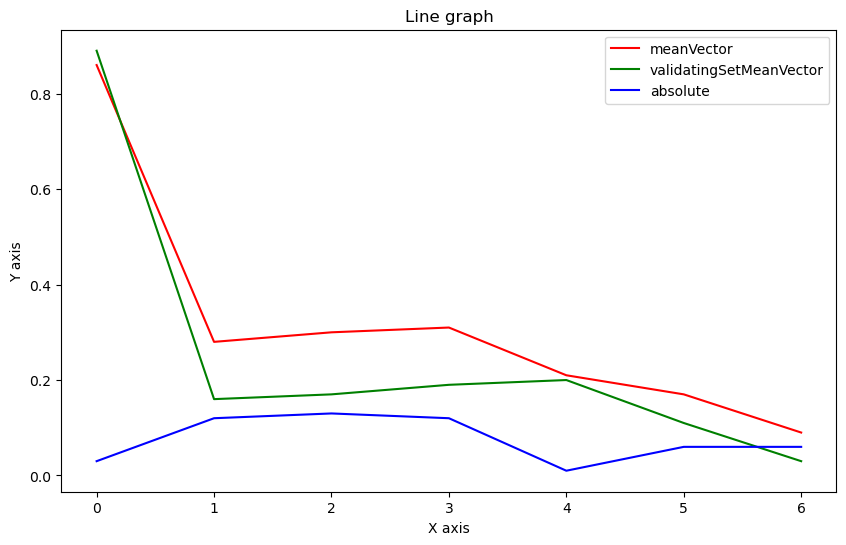

In [236]:
DataProcessing.showVectorPlot(meanVector, validatingSetMeanVector)